<a href="https://colab.research.google.com/github/HassanFrazKhan/Barclays-Stock-Price-Prediction-Using-Advanced-ML-/blob/main/barclays_stock_pred.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Import Necessary Libraries:**

Ensure you have the required libraries installed:

In [ ]:
import numpy as np
import pandas as pd
import yfinance as yf
import datetime
from datetime import date
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from statsmodels.tsa.arima.model import ARIMA
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler


from prophet import Prophet
from prophet.diagnostics import performance_metrics
from prophet.diagnostics import cross_validation
from prophet.plot import plot_cross_validation_metric





#**Fetching Barclays Stock Data:**
 New section
 The ticker symbol for Barclays on the London Stock Exchange is BARC.L.

In [ ]:
# Download Barclays Stock Data
# Define the ticker symbol
ticker_symbol = 'BARC.L'


# Define the date range
start_date = '2014-01-01'
end_date = date.today().strftime('%Y-%m-%d')

# Download historical stock data
barclays_data = yf.download(ticker_symbol, start=start_date, end=end_date, interval='1d')

# Ensure the data is sorted by date
barclays_data.sort_index(inplace=True)

[*********************100%***********************]  1 of 1 completed


#**Calculating Technical Indicators:**

We'll compute the following features using past data (shifted by one day to prevent data leakage):

Moving Averages: 5-day, 10-day, and 50-day moving averages of the closing price.


Daily Returns: Percentage change in the closing price from the previous day.


Volatility: Rolling standard deviation of daily returns over a 10-day window.

In [ ]:
# Calculate moving averages (shifted by 1 day)
barclays_data['MA_5'] = barclays_data['Close'].rolling(window=5).mean().shift(1)
barclays_data['MA_10'] = barclays_data['Close'].rolling(window=10).mean().shift(1)
barclays_data['MA_50'] = barclays_data['Close'].rolling(window=50).mean().shift(1)

# Calculate daily returns (shifted by 1 day)
barclays_data['Daily_Returns'] = barclays_data['Close'].pct_change().shift(1) * 100

# Calculate volatility (rolling standard deviation of returns, shifted by 1 day)
barclays_data['Volatility'] = barclays_data['Daily_Returns'].rolling(window=10).std().shift(1)

# Drop rows with NaN values resulting from rolling calculations
barclays_data.dropna(inplace=True)



**Defining Features and Target Variable:**
We'll define our feature set (X) and target variable (y):

In [ ]:
# Define features (X) and target variable (y)
X = barclays_data[['MA_5', 'MA_10', 'MA_50', 'Daily_Returns', 'Volatility']]
y = barclays_data['Close']


#**Splitting the Data into Training and Testing Sets:**

We'll split the data based on time to create training and testing datasets:

In [ ]:
# Split data into training and testing sets
train_data = barclays_data[barclays_data.index < '2023-01-01']
test_data = barclays_data[barclays_data.index >= '2023-01-01']

X_train = train_data[['MA_5', 'MA_10', 'MA_50', 'Daily_Returns', 'Volatility']]
y_train = train_data['Close']
X_test = test_data[['MA_5', 'MA_10', 'MA_50', 'Daily_Returns', 'Volatility']]
y_test = test_data['Close']

Saving the Datasets to CSV Files:

Finally, we'll save the datasets to CSV files for future use:

In [ ]:
# Save datasets to CSV files
train_data.to_csv("barclays_train_data.csv")
test_data.to_csv("barclays_test_data.csv")
X_train.to_csv("barclays_train_features.csv")
y_train.to_csv("barclays_train_target.csv")
X_test.to_csv("barclays_test_features.csv")
y_test.to_csv("barclays_test_target.csv")

In [ ]:
# Printing the total number of days and features in the dataset
print('Total number of days present in the dataset:', barclays_data.shape[0])
print('Total number of fields present in the dataset:', barclays_data.shape[1])

Total number of days present in the dataset: 2770
Total number of fields present in the dataset: 10


In [ ]:
# Checking the null values
print('Null Values:',barclays_data.isnull().values.sum())
print('NA values:',barclays_data.isnull().values.any())

Null Values: 0
NA values: False


In [ ]:
barclays_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2770 entries, 2014-03-13 to 2025-02-27
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   (Close, BARC.L)    2770 non-null   float64
 1   (High, BARC.L)     2770 non-null   float64
 2   (Low, BARC.L)      2770 non-null   float64
 3   (Open, BARC.L)     2770 non-null   float64
 4   (Volume, BARC.L)   2770 non-null   int64  
 5   (MA_5, )           2770 non-null   float64
 6   (MA_10, )          2770 non-null   float64
 7   (MA_50, )          2770 non-null   float64
 8   (Daily_Returns, )  2770 non-null   float64
 9   (Volatility, )     2770 non-null   float64
dtypes: float64(9), int64(1)
memory usage: 238.0 KB


In [ ]:
barclays_data.head()

Price,Close,High,Low,Open,Volume,MA_5,MA_10,MA_50,Daily_Returns,Volatility
Ticker,BARC.L,BARC.L,BARC.L,BARC.L,BARC.L,,,,,
Date,,,,,,,,,,
2014-03-13,234.928253,239.613870,234.230400,234.778719,64888340,241.966644,246.502707,266.085543,-1.016286,1.490312
2014-03-14,230.442047,237.919077,227.589817,234.878430,73837468,238.447446,244.683293,265.380435,0.812821,1.452715
2014-03-17,230.342346,232.951335,229.245709,231.389133,46130614,235.017984,242.594711,264.549718,-1.909607,1.503707
2014-03-18,235.327072,237.271097,229.494982,231.090088,57727630,232.834692,240.919855,263.624303,-0.043265,1.548835
2014-03-19,240.760361,242.554851,231.454948,237.769549,64501431,232.814764,239.235034,262.729803,2.164051,1.537759


**Flatten the MultiIndex Columns:**

First, we'll flatten the MultiIndex columns to simplify the DataFrame structure.

In [ ]:
# Flatten MultiIndex columns
barclays_data.columns = ['_'.join(filter(None, col)).strip() for col in barclays_data.columns.values]

# Display the updated columns
print(barclays_data.columns)


Index(['Close_BARC.L', 'High_BARC.L', 'Low_BARC.L', 'Open_BARC.L',
       'Volume_BARC.L', 'MA_5', 'MA_10', 'MA_50', 'Daily_Returns',
       'Volatility'],
      dtype='object')


Resample the Data:

Next, we'll resample the data to weekly, monthly, and yearly frequencies. For each period, we'll compute the opening price (first value), closing price (last value), highest price, lowest price, and total volume.

In [ ]:
# Resample to weekly frequency
barclays_weekly = barclays_data.resample('W').agg({
    'Open_BARC.L': 'first',
    'High_BARC.L': 'max',
    'Low_BARC.L': 'min',
    'Close_BARC.L': 'last',
    'Volume_BARC.L': 'sum'
})

# Resample to monthly frequency
barclays_monthly = barclays_data.resample('M').agg({
    'Open_BARC.L': 'first',
    'High_BARC.L': 'max',
    'Low_BARC.L': 'min',
    'Close_BARC.L': 'last',
    'Volume_BARC.L': 'sum'
})

# Resample to yearly frequency
barclays_yearly = barclays_data.resample('A').agg({
    'Open_BARC.L': 'first',
    'High_BARC.L': 'max',
    'Low_BARC.L': 'min',
    'Close_BARC.L': 'last',
    'Volume_BARC.L': 'sum'
})


# **Plot the Data:**

We'll create subplots to visualize the open and closing prices for daily, weekly, monthly, and yearly data.

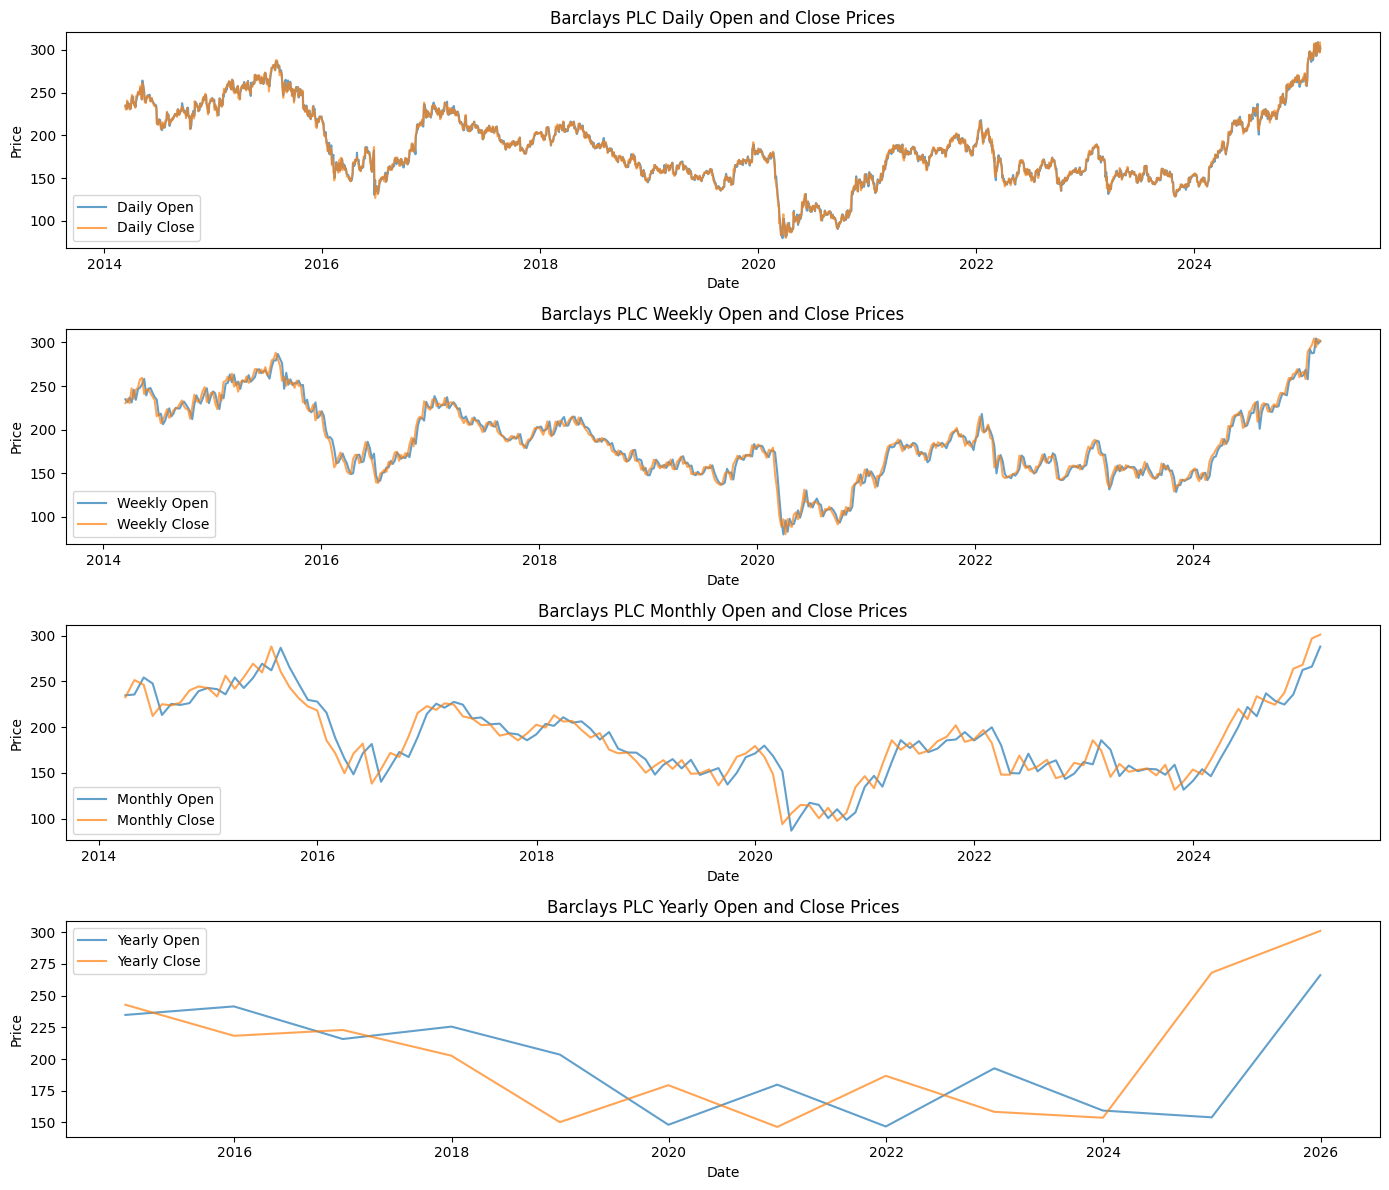

In [ ]:

plt.figure(figsize=(14, 12))

# Daily Open and Close Prices
plt.subplot(4, 1, 1)
plt.plot(barclays_data.index, barclays_data['Open_BARC.L'], label='Daily Open', alpha=0.7)
plt.plot(barclays_data.index, barclays_data['Close_BARC.L'], label='Daily Close', alpha=0.7)
plt.title('Barclays PLC Daily Open and Close Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

# Weekly Open and Close Prices
plt.subplot(4, 1, 2)
plt.plot(barclays_weekly.index, barclays_weekly['Open_BARC.L'], label='Weekly Open', alpha=0.7)
plt.plot(barclays_weekly.index, barclays_weekly['Close_BARC.L'], label='Weekly Close', alpha=0.7)
plt.title('Barclays PLC Weekly Open and Close Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

# Monthly Open and Close Prices
plt.subplot(4, 1, 3)
plt.plot(barclays_monthly.index, barclays_monthly['Open_BARC.L'], label='Monthly Open', alpha=0.7)
plt.plot(barclays_monthly.index, barclays_monthly['Close_BARC.L'], label='Monthly Close', alpha=0.7)
plt.title('Barclays PLC Monthly Open and Close Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

# Yearly Open and Close Prices
plt.subplot(4, 1, 4)
plt.plot(barclays_yearly.index, barclays_yearly['Open_BARC.L'], label='Yearly Open', alpha=0.7)
plt.plot(barclays_yearly.index, barclays_yearly['Close_BARC.L'], label='Yearly Close', alpha=0.7)
plt.title('Barclays PLC Yearly Open and Close Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

plt.tight_layout()
plt.show()


# **LSTM Model**

In [ ]:
# Utility function to create dataset
def create_dataset(dataset, time_step=1):
    X, Y = [], []
    for i in range(len(dataset) - time_step - 1):
        a = dataset[i:(i + time_step), 0]
        X.append(a)
        Y.append(dataset[i + time_step, 0])
    return np.array(X), np.array(Y)

time_step = 100
future_steps = 30


**Forecasting OPEN Price for LSTM Model**

In [ ]:
# Scale the Open price
scaler_open = MinMaxScaler(feature_range=(0, 1))
scaled_open = scaler_open.fit_transform(barclays_data['Open_BARC.L'].values.reshape(-1, 1))

# Create dataset for Open price
X_open, Y_open = create_dataset(scaled_open, time_step)
X_open = X_open.reshape(X_open.shape[0], X_open.shape[1], 1)

# Split data into training and testing sets for Open price
train_size_open = int(len(X_open) * 0.8)
X_train_open, X_test_open = X_open[:train_size_open], X_open[train_size_open:]
Y_train_open, Y_test_open = Y_open[:train_size_open], Y_open[train_size_open:]

# Build LSTM model for Open price
lstm_model_open = Sequential()
lstm_model_open.add(LSTM(50, return_sequences=True, input_shape=(time_step, 1)))
lstm_model_open.add(LSTM(50, return_sequences=False))
lstm_model_open.add(Dense(25))
lstm_model_open.add(Dense(1))
lstm_model_open.compile(optimizer='adam', loss='mean_squared_error')
lstm_model_open.fit(X_train_open, Y_train_open, batch_size=1, epochs=1)

# Forecast future 30 days for Open price (recursive forecasting)
last_window_open = scaled_open[-time_step:]
temp_input_open = list(last_window_open.flatten())
lst_output_open = []
for i in range(future_steps):
    x_input_open = np.array(temp_input_open[-time_step:]).reshape(1, time_step, 1)
    yhat_open = lstm_model_open.predict(x_input_open, verbose=0)
    lst_output_open.append(yhat_open[0][0])
    temp_input_open.append(yhat_open[0][0])
future_predictions_open = scaler_open.inverse_transform(np.array(lst_output_open).reshape(-1, 1))



2135/2135 ━━━━━━━━━━━━━━━━━━━━ 99s 45ms/step - loss: 0.0037


**Evaluate Test Performance and Plot Actual vs Predicted for Open Price for LSTM**

17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step

Open Price Model Evaluation Metrics:
MSE: 27.5749
RMSE: 5.2512
MAE: 3.8612
R²: 0.9875


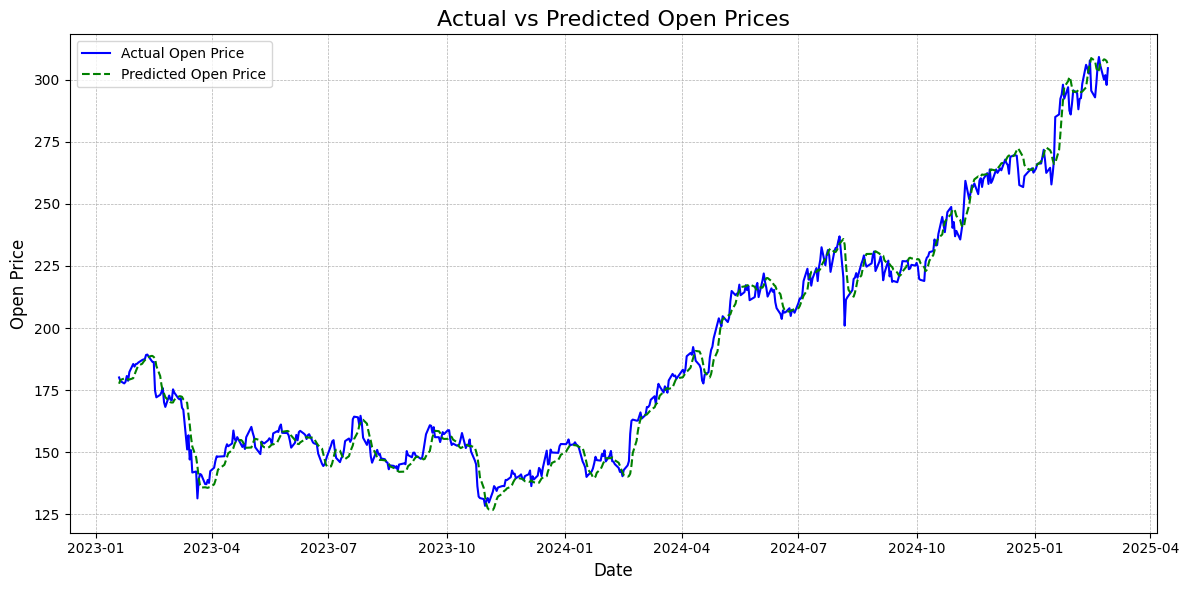

In [ ]:

Y_test_open_actual = scaler_open.inverse_transform(Y_test_open.reshape(-1, 1))
lstm_test_predictions_open = lstm_model_open.predict(X_test_open)
lstm_test_predictions_open = scaler_open.inverse_transform(lstm_test_predictions_open)

open_mse = mean_squared_error(Y_test_open_actual, lstm_test_predictions_open)
open_rmse = np.sqrt(open_mse)
open_mae = mean_absolute_error(Y_test_open_actual, lstm_test_predictions_open)
open_r2 = r2_score(Y_test_open_actual, lstm_test_predictions_open)

print("\nOpen Price Model Evaluation Metrics:")
print(f"MSE: {open_mse:.4f}")
print(f"RMSE: {open_rmse:.4f}")
print(f"MAE: {open_mae:.4f}")
print(f"R²: {open_r2:.4f}")

# Get the dates from the index of the original data corresponding to the test data
# Define dates_test_open similar to dates_test_close
dates_test_open = barclays_data.index[train_size_open + time_step + 1:train_size_open + time_step + 1 + len(Y_test_open)]


plt.figure(figsize=(12,6))
plt.plot(dates_test_open, Y_test_open_actual, label='Actual Open Price', color='blue')
plt.plot(dates_test_open, lstm_test_predictions_open, label='Predicted Open Price', color='green', linestyle='--')
plt.title('Actual vs Predicted Open Prices', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Open Price', fontsize=12)
plt.legend()
plt.grid(visible=True, linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

**Forecasting CLOSE Price LSTM Model**

In [ ]:
# Scale the Close price
scaler_close = MinMaxScaler(feature_range=(0, 1))
scaled_close = scaler_close.fit_transform(barclays_data['Close_BARC.L'].values.reshape(-1, 1))

# Create dataset for Close price
X_close, Y_close = create_dataset(scaled_close, time_step)
X_close = X_close.reshape(X_close.shape[0], X_close.shape[1], 1)

# Split data into training and testing sets for Close price
train_size_close = int(len(X_close) * 0.8)
X_train_close, X_test_close = X_close[:train_size_close], X_close[train_size_close:]
Y_train_close, Y_test_close = Y_close[:train_size_close], Y_close[train_size_close:]

# Build LSTM model for Close price
lstm_model_close = Sequential()
lstm_model_close.add(LSTM(50, return_sequences=True, input_shape=(time_step, 1)))
lstm_model_close.add(LSTM(50, return_sequences=False))
lstm_model_close.add(Dense(25))
lstm_model_close.add(Dense(1))
lstm_model_close.compile(optimizer='adam', loss='mean_squared_error')
lstm_model_close.fit(X_train_close, Y_train_close, batch_size=1, epochs=1)

# Forecast future 30 days for Close price (recursive forecasting)
last_window_close = scaled_close[-time_step:]
temp_input_close = list(last_window_close.flatten())
lst_output_close = []
for i in range(future_steps):
    x_input_close = np.array(temp_input_close[-time_step:]).reshape(1, time_step, 1)
    yhat_close = lstm_model_close.predict(x_input_close, verbose=0)
    lst_output_close.append(yhat_close[0][0])
    temp_input_close.append(yhat_close[0][0])
future_predictions_close = scaler_close.inverse_transform(np.array(lst_output_close).reshape(-1, 1))



2135/2135 ━━━━━━━━━━━━━━━━━━━━ 94s 43ms/step - loss: 0.0052


**Evaluate Test Performance and Plot Actual vs Predicted for Close Price for LSTM**

17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step

Close Price Model Evaluation Metrics:
MSE: 31.7159
RMSE: 5.6317
MAE: 4.2023
R²: 0.9858


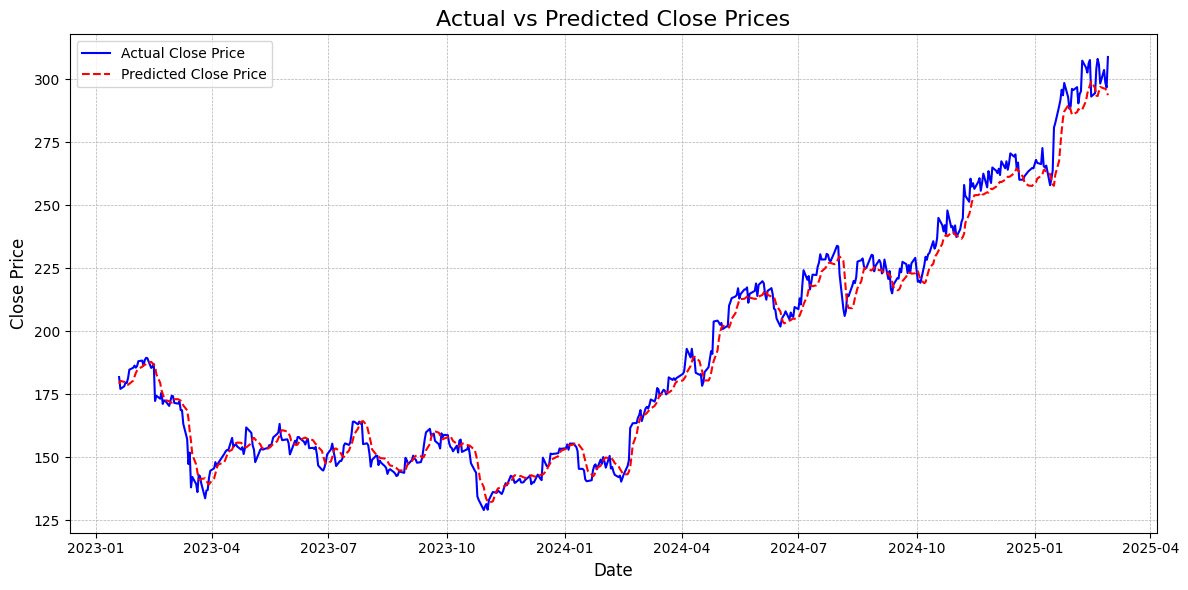

In [ ]:

Y_test_close_actual = scaler_close.inverse_transform(Y_test_close.reshape(-1, 1))
lstm_test_predictions_close = lstm_model_close.predict(X_test_close)
lstm_test_predictions_close = scaler_close.inverse_transform(lstm_test_predictions_close)

close_mse = mean_squared_error(Y_test_close_actual, lstm_test_predictions_close)
close_rmse = np.sqrt(close_mse)
close_mae = mean_absolute_error(Y_test_close_actual, lstm_test_predictions_close)
close_r2 = r2_score(Y_test_close_actual, lstm_test_predictions_close)

print("\nClose Price Model Evaluation Metrics:")
print(f"MSE: {close_mse:.4f}")
print(f"RMSE: {close_rmse:.4f}")
print(f"MAE: {close_mae:.4f}")
print(f"R²: {close_r2:.4f}")

# Get the dates from the index of the original data corresponding to the test data
dates_test_close = barclays_data.index[train_size_close + time_step + 1:train_size_close + time_step + 1 + len(Y_test_close)]


plt.figure(figsize=(12,6))
plt.plot(dates_test_close, Y_test_close_actual, label='Actual Close Price', color='blue')
plt.plot(dates_test_close, lstm_test_predictions_close, label='Predicted Close Price', color='red', linestyle='--')
plt.title('Actual vs Predicted Close Prices', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Close Price', fontsize=12)
plt.legend()
plt.grid(visible=True, linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

30 Days Plot Future Predictions for LSTM


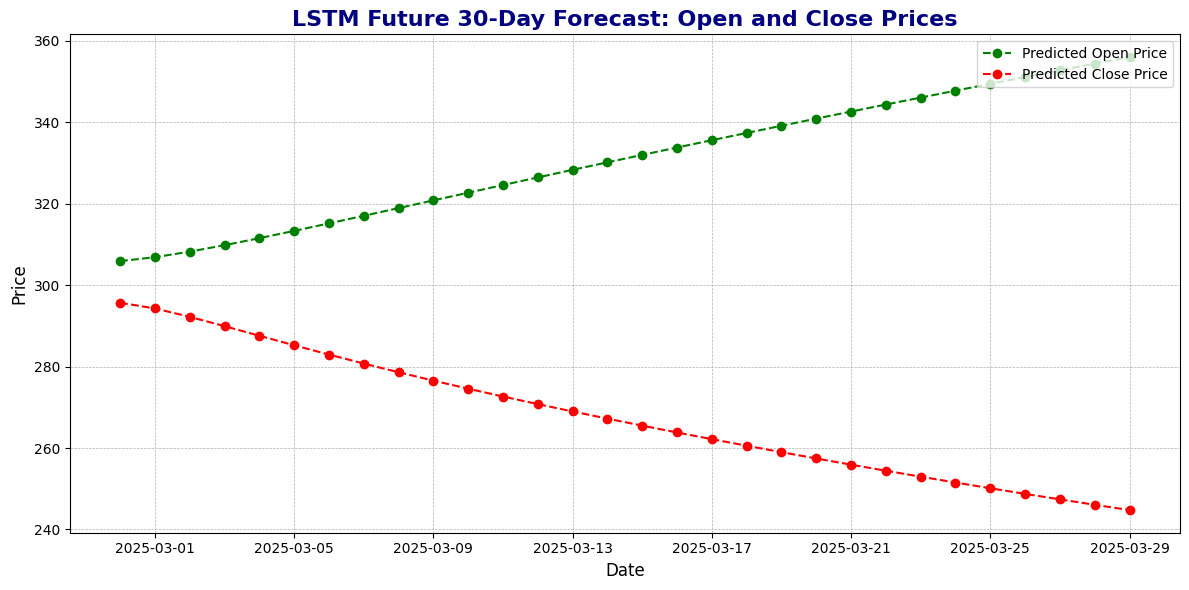

In [ ]:
# Generate future dates (using the last available date from barclays_data)
# last_date = pd.to_datetime(barclays_data['Date'].iloc[-1])  # Original line causing error

# Assuming 'Date' was flattened to 'Date_' or used as index:
# Check if 'Date_' exists:
if 'Date_' in barclays_data.columns:
    last_date = pd.to_datetime(barclays_data['Date_'].iloc[-1])
# Otherwise, assume 'Date' was used as index:
else:
    last_date = barclays_data.index[-1]

future_dates = [last_date + pd.DateOffset(days=i+1) for i in range(future_steps)]

# Create a DataFrame with predicted Open and Close prices
future_df = pd.DataFrame({
    'Date': future_dates,
    'Predicted Open': future_predictions_open.flatten(),
    'Predicted Close': future_predictions_close.flatten()
})


plt.figure(figsize=(12,6))
plt.plot(future_df['Date'], future_df['Predicted Open'], label='Predicted Open Price', linestyle='--', marker='o', color='green')
plt.plot(future_df['Date'], future_df['Predicted Close'], label='Predicted Close Price', linestyle='--', marker='o', color='red')
plt.title('LSTM Future 30-Day Forecast: Open and Close Prices', fontsize=16, color='navy', weight='bold')
plt.xlabel('Date', fontsize=12, color='k')
plt.ylabel('Price', fontsize=12, color='k')
plt.legend(frameon=True, loc='upper right', fontsize=10)
plt.grid(visible=True, linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()


In [ ]:

print("Future 30-day Predictions (Open & Close):")
print(future_df)

Future 30-day Predictions (Open & Close):
         Date  Predicted Open  Predicted Close
0  2025-02-28      305.902832       295.673767
1  2025-03-01      306.855011       294.268524
2  2025-03-02      308.222748       292.217712
3  2025-03-03      309.811310       289.924591
4  2025-03-04      311.526581       287.568542
5  2025-03-05      313.319061       285.231354
6  2025-03-06      315.159515       282.950134
7  2025-03-07      317.029144       280.740845
8  2025-03-08      318.914337       278.608398
9  2025-03-09      320.805267       276.551727
10 2025-03-10      322.694550       274.566406
11 2025-03-11      324.576874       272.646576
12 2025-03-12      326.448425       270.785797
13 2025-03-13      328.306702       268.977814
14 2025-03-14      330.150146       267.217133
15 2025-03-15      331.977997       265.498810
16 2025-03-16      333.789948       263.819061
17 2025-03-17      335.586121       262.174774
18 2025-03-18      337.366821       260.563690
19 2025-03-19     

# **Prophat Model**

In [ ]:
import pandas as pd
from prophet import Prophet

# --- Verify the flattened column names in test_data ---
print("Columns available in test_data:", test_data.columns)

# Flatten MultiIndex columns
test_data.columns = ['_'.join(filter(None, col)).strip() for col in test_data.columns.values]


# Use string indexing to refer to the desired columns
close_col = 'Close_BARC.L'
open_col = 'Open_BARC.L'

if close_col not in test_data.columns:
    raise KeyError(f"Column {close_col} not found in test_data. Available columns: {test_data.columns}")
if open_col not in test_data.columns:
    raise KeyError(f"Column {open_col} not found in test_data. Available columns: {test_data.columns}")

# Prepare data for Prophet for close price
close_data = barclays_data[['Close_BARC.L']].reset_index()
close_data.rename(columns={'Date': 'ds', 'Close_BARC.L': 'y'}, inplace=True)

# Prepare data for Prophet for open price
open_data = barclays_data[['Open_BARC.L']].reset_index()
open_data.rename(columns={'Date': 'ds', 'Open_BARC.L': 'y'}, inplace=True)



Columns available in test_data: MultiIndex([(        'Close', 'BARC.L'),
            (         'High', 'BARC.L'),
            (          'Low', 'BARC.L'),
            (         'Open', 'BARC.L'),
            (       'Volume', 'BARC.L'),
            (         'MA_5',       ''),
            (        'MA_10',       ''),
            (        'MA_50',       ''),
            ('Daily_Returns',       ''),
            (   'Volatility',       '')],
           names=['Price', 'Ticker'])


In [ ]:
# Initialize and fit the Prophet model for Close price
close_model = Prophet(daily_seasonality=True)
close_model.fit(close_data)

# Create a DataFrame for future dates (no extra periods for in-sample forecasting)
close_future = close_model.make_future_dataframe(periods=0)
close_forecast = close_model.predict(close_future)

# Initialize and fit the Prophet model for Open price
open_model = Prophet(daily_seasonality=True)
open_model.fit(open_data)

# Create a DataFrame for future dates (no extra periods for in-sample forecasting)
open_future = open_model.make_future_dataframe(periods=0)
open_forecast = open_model.predict(open_future)


DEBUG:cmdstanpy:input tempfile: /tmp/tmp10ud0opx/2izxnw8j.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp10ud0opx/h440fozj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=3219', 'data', 'file=/tmp/tmp10ud0opx/2izxnw8j.json', 'init=/tmp/tmp10ud0opx/h440fozj.json', 'output', 'file=/tmp/tmp10ud0opx/prophet_modelg2_1p6ky/prophet_model-20250228003819.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
00:38:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
00:38:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp10ud0opx/l6c9jlxi.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp10ud0opx/ibg267aa.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/l


Open Price Model Evaluation Metrics:
MSE: 317.1099
RMSE: 17.8076
MAE: 13.7184
R²: 0.8236


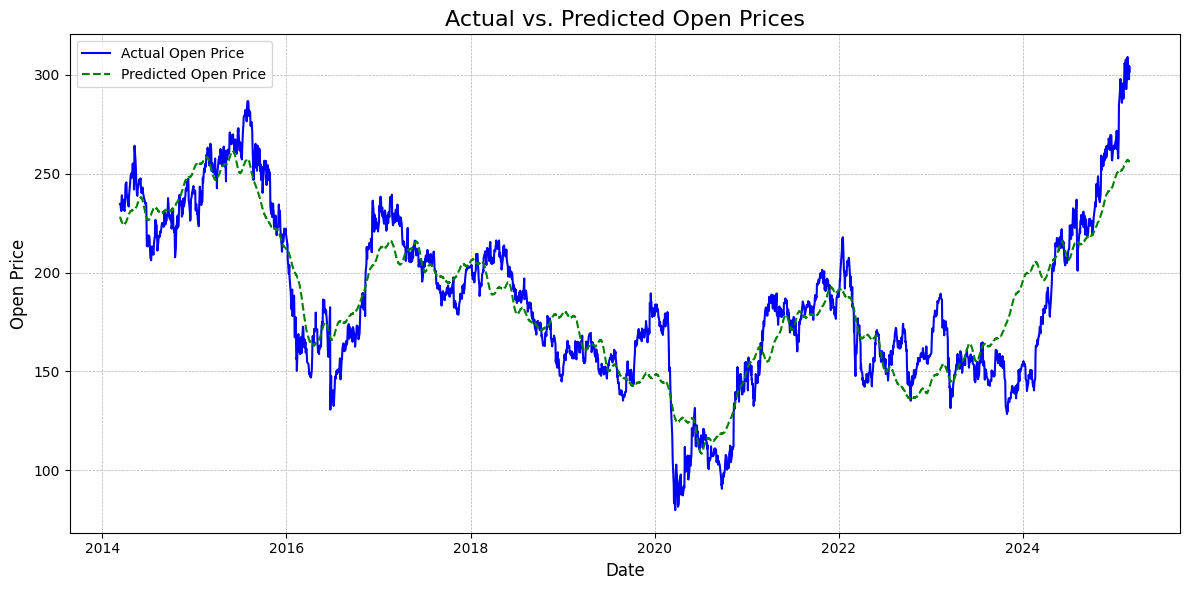

In [ ]:
# Merge actual and predicted values for Open price
open_merged = pd.merge(open_data, open_forecast[['ds', 'yhat']], on='ds')

# Calculate metrics for Open price
open_mse = mean_squared_error(open_merged['y'], open_merged['yhat'])
open_rmse = np.sqrt(open_mse)
open_mae = mean_absolute_error(open_merged['y'], open_merged['yhat'])
open_r2 = r2_score(open_merged['y'], open_merged['yhat'])

print("\nOpen Price Model Evaluation Metrics:")
print(f"MSE: {open_mse:.4f}")
print(f"RMSE: {open_rmse:.4f}")
print(f"MAE: {open_mae:.4f}")
print(f"R²: {open_r2:.4f}")


# Plot for Open Price
plt.figure(figsize=(12, 6))
plt.plot(open_merged['ds'], open_merged['y'], label='Actual Open Price', color='blue')
plt.plot(open_merged['ds'], open_merged['yhat'], label='Predicted Open Price', color='green', linestyle='--')
plt.title('Actual vs. Predicted Open Prices', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Open Price', fontsize=12)
plt.legend()
plt.grid(visible=True, linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()



Close Price Model Evaluation Metrics:
MSE: 330.2577
RMSE: 18.1730
MAE: 14.0240
R²: 0.8163


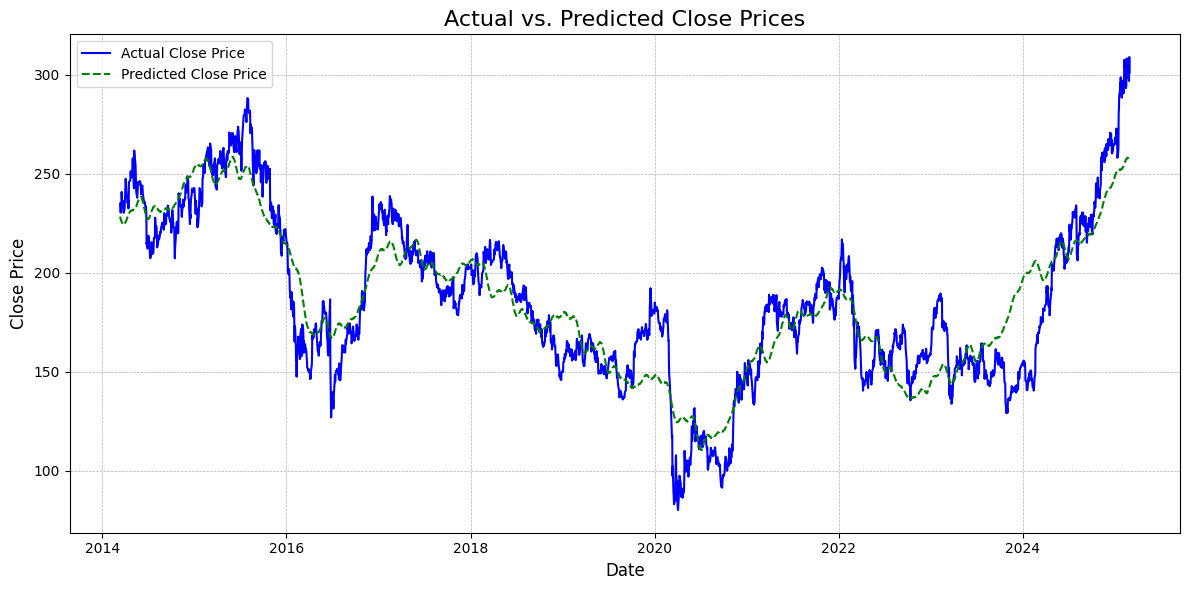

In [ ]:
# Merge actual and predicted values for Close price
close_merged = pd.merge(close_data, close_forecast[['ds', 'yhat']], on='ds')

# Calculate metrics for Close price
close_mse = mean_squared_error(close_merged['y'], close_merged['yhat'])
close_rmse = np.sqrt(close_mse)
close_mae = mean_absolute_error(close_merged['y'], close_merged['yhat'])
close_r2 = r2_score(close_merged['y'], close_merged['yhat'])

print("\nClose Price Model Evaluation Metrics:")
print(f"MSE: {close_mse:.4f}")
print(f"RMSE: {close_rmse:.4f}")
print(f"MAE: {close_mae:.4f}")
print(f"R²: {close_r2:.4f}")

# Plot for Close Price
plt.figure(figsize=(12, 6))
plt.plot(close_merged['ds'], close_merged['y'], label='Actual Close Price', color='blue')
plt.plot(close_merged['ds'], close_merged['yhat'], label='Predicted Close Price', color='green', linestyle='--')
plt.title('Actual vs. Predicted Close Prices', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Close Price', fontsize=12)
plt.legend()
plt.grid(visible=True, linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()



#  30 Days Plot Future Predictions for Prophet

In [ ]:
# Create a DataFrame for future dates (30 days)
open_future = open_model.make_future_dataframe(periods=30)
# Filter the open_future dataframe to include only the future 30 days by removing the current and past days
open_future = open_future[open_future['ds'] > open_data['ds'].max()]
open_forecast = open_model.predict(open_future)


# Initialize and fit the Prophet model for Close price
close_model = Prophet(daily_seasonality=True)
close_model.fit(close_data)

# Create a DataFrame for future dates (30 days)
close_future = close_model.make_future_dataframe(periods=30)
# Filter the close_future dataframe to include only the future 30 days by removing the current and past days
close_future = close_future[close_future['ds'] > close_data['ds'].max()]
close_forecast = close_model.predict(close_future)



DEBUG:cmdstanpy:input tempfile: /tmp/tmp10ud0opx/fpakauwj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp10ud0opx/hjw6mpu7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=17306', 'data', 'file=/tmp/tmp10ud0opx/fpakauwj.json', 'init=/tmp/tmp10ud0opx/hjw6mpu7.json', 'output', 'file=/tmp/tmp10ud0opx/prophet_modelz7ch2fzq/prophet_model-20250228003824.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
00:38:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
00:38:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


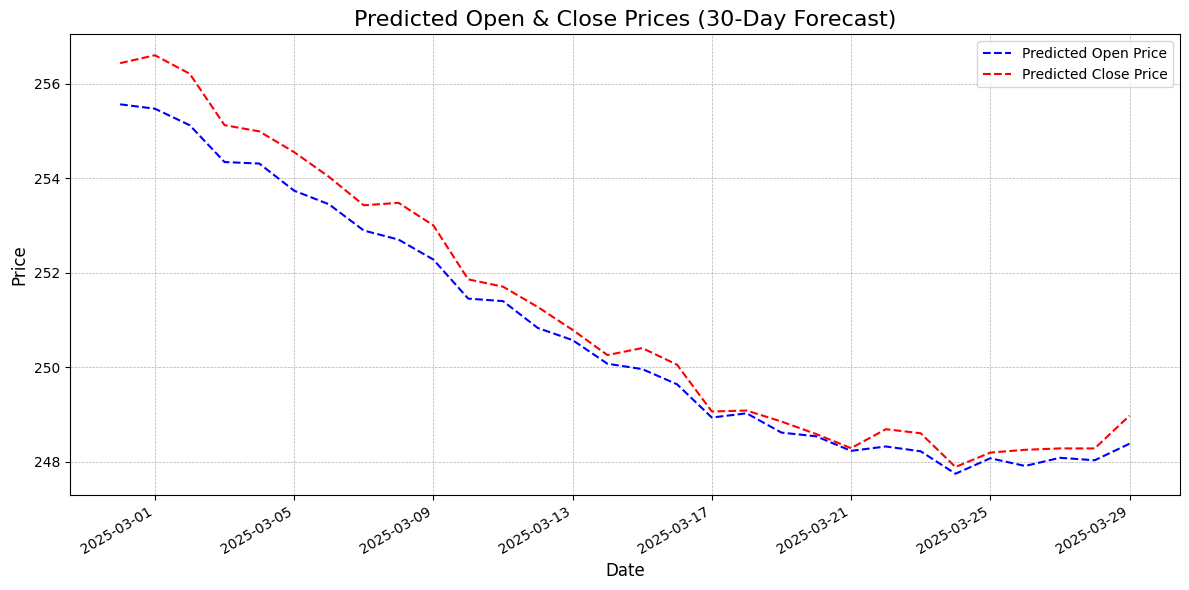

In [ ]:
# Merge Open and Close forecasts into a single DataFrame
merged_forecast = pd.merge(open_forecast[['ds', 'yhat']], close_forecast[['ds', 'yhat']], on='ds', suffixes=('_open', '_close'))


# Plotting Open and Close Price forecasts together
plt.figure(figsize=(12, 6))
plt.plot(merged_forecast['ds'], merged_forecast['yhat_open'], label='Predicted Open Price', color='blue', linestyle='--')
plt.plot(merged_forecast['ds'], merged_forecast['yhat_close'], label='Predicted Close Price', color='red', linestyle='--')


# Formatting the plot
plt.title('Predicted Open & Close Prices (30-Day Forecast)', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.gcf().autofmt_xdate()
plt.legend()
plt.grid(visible=True, linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()


In [ ]:
# Print the combined forecast table
print("\n30-Day Open and Close Price Forecast:")
print(merged_forecast.tail(30))  # Display the last 30 rows



30-Day Open and Close Price Forecast:
           ds   yhat_open  yhat_close
0  2025-02-28  255.565686  256.437288
1  2025-03-01  255.472904  256.604283
2  2025-03-02  255.123938  256.212454
3  2025-03-03  254.344510  255.124978
4  2025-03-04  254.312121  254.992916
5  2025-03-05  253.737799  254.553983
6  2025-03-06  253.450763  254.031393
7  2025-03-07  252.895340  253.429555
8  2025-03-08  252.702741  253.480653
9  2025-03-09  252.280318  253.003494
10 2025-03-10  251.453964  251.861797
11 2025-03-11  251.401053  251.706807
12 2025-03-12  250.832223  251.276079
13 2025-03-13  250.576058  250.792345
14 2025-03-14  250.076052  250.259233
15 2025-03-15  249.962404  250.407873
16 2025-03-16  249.641315  250.055770
17 2025-03-17  248.937407  249.065116
18 2025-03-18  249.026693  249.085439
19 2025-03-19  248.618381  248.852400
20 2025-03-20  248.539574  248.586691
21 2025-03-21  248.232247  248.289778
22 2025-03-22  248.325052  248.690520
23 2025-03-23  248.222617  248.604065
24 2025-03-